In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from collections import Counter
import scipy.sparse as sp 



from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns

# start auto-reloading certain libraries marked with %aimport
%load_ext autoreload
%autoreload 1
# add new source file to auto-reload
%aimport capstone_2
# add function from auto-reloading module
import capstone_2 as cap

from sklearn.decomposition import LatentDirichletAllocation

# Gensim <- need to download this
# import gensim
from sklearn.metrics import pairwise_distances


In [5]:
df_info = pd.read_csv('/Users/mattdevor/galvanize/capstone_2/data/seinfeld-chronicles/episode_info.csv')
df_info.head()

,OverallEPNo,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID,IMDB_Rating
0,0,1,0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,S01E00,7.7
1,1,1,1,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01,7.7
2,2,1,2,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,S01E02,7.7
3,3,1,3,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E03,7.5
4,4,1,4,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E04,7.7


In [6]:
df_scripts = pd.read_csv('/Users/mattdevor/galvanize/capstone_2/data/seinfeld-chronicles/scripts.csv')
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E00,1.0
2,2,GEORGE,Are you through?,1.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E00,1.0


In [7]:
df_scripts.EpisodeNo = np.where(df_scripts.SEID =='S01E00', 0.0, df_scripts.EpisodeNo)

In [8]:
df_scripts.EpisodeNo.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [9]:
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0


In [10]:
df_scripts.shape

(54616, 6)

In [11]:
df_scripts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54616 entries, 0 to 54615
Data columns (total 6 columns):
Unnamed: 0    54616 non-null int64
Character     54616 non-null object
Dialogue      54606 non-null object
EpisodeNo     54616 non-null float64
SEID          54616 non-null object
Season        54616 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.5+ MB


In [12]:
df_scripts[df_scripts.isnull().any(axis=1)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
13529,13529,** Pies - Just in case you did not know what t...,NaN,7.0,S04E07,4.0
14938,14938,"[On the bright side, Kramer and George arrive ...",NaN,12.0,S04E12,4.0
18353,18353,(The show begins. There are three different se...,NaN,24.0,S04E24,4.0
18354,18354,(Jerry's doing his stand-up routine at a comed...,NaN,24.0,S04E24,4.0
18355,18355,"We see the title 'Jerry', then, sitting at the...",NaN,24.0,S04E24,4.0
42939,42939,Definitions of several items in the Chicken Ro...,NaN,8.0,S08E08,8.0
45847,45847,HAL,NaN,18.0,S08E18,8.0
49651,49651,Notice,NaN,8.0,S09E08,9.0
50013,50013,The definition of Sari or Saree is,NaN,8.0,S09E08,9.0
53142,53142,MONTAGE,NaN,18.0,S09E18,9.0


In [13]:
df_scripts = df_scripts.dropna()

In [14]:
# How many unique Characters are there in the scripts
df_scripts['Character'].unique().shape

(1631,)

In [15]:
df_scripts['Character'].value_counts()

JERRY                                                            14786
GEORGE                                                            9708
ELAINE                                                            7983
KRAMER                                                            6664
NEWMAN                                                             640
MORTY                                                              505
HELEN                                                              471
FRANK                                                              436
SUSAN                                                              379
[Setting                                                           293
ESTELLE                                                            286
PETERMAN                                                           191
PUDDY                                                              162
WOMAN                                                              157
MAN   

In [16]:
# How many unique Characters are there in the scripts
character_lines = df_scripts['Character'].value_counts()
character_lines = character_lines.reset_index()

In [17]:
df_scripts[(df_scripts['SEID']=='S01E01') & (df_scripts['Season']==1.0)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
211,211,JERRY,"So, Im on line at the supermarket. Two women i...",1.0,S01E01,1.0
212,212,AUDIENCE,Cheque.,1.0,S01E01,1.0
213,213,JERRY,"Cheque. Now, the fact is, if its a woman in fr...",1.0,S01E01,1.0
214,214,JERRY,Whats that one?,1.0,S01E01,1.0
215,215,ELAINE,Coccoon II The Return. I guess they didnt like...,1.0,S01E01,1.0
216,216,JERRY,Maybe they came back for Chinese food. Yknow M...,1.0,S01E01,1.0
217,217,ELAINE,"Okay, whatre we doing here? I have seen everyt...",1.0,S01E01,1.0
218,218,JERRY,Oh yeah? I dont believe youve seen... this.,1.0,S01E01,1.0
219,219,ELAINE,"Oh, lovely.",1.0,S01E01,1.0
220,220,JERRY,Yeah.,1.0,S01E01,1.0


In [18]:
df_scripts[df_scripts['SEID']=='S01E01']

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
211,211,JERRY,"So, Im on line at the supermarket. Two women i...",1.0,S01E01,1.0
212,212,AUDIENCE,Cheque.,1.0,S01E01,1.0
213,213,JERRY,"Cheque. Now, the fact is, if its a woman in fr...",1.0,S01E01,1.0
214,214,JERRY,Whats that one?,1.0,S01E01,1.0
215,215,ELAINE,Coccoon II The Return. I guess they didnt like...,1.0,S01E01,1.0
216,216,JERRY,Maybe they came back for Chinese food. Yknow M...,1.0,S01E01,1.0
217,217,ELAINE,"Okay, whatre we doing here? I have seen everyt...",1.0,S01E01,1.0
218,218,JERRY,Oh yeah? I dont believe youve seen... this.,1.0,S01E01,1.0
219,219,ELAINE,"Oh, lovely.",1.0,S01E01,1.0
220,220,JERRY,Yeah.,1.0,S01E01,1.0


In [19]:
df_scripts[(df_scripts['EpisodeNo']==0.0) & (df_scripts['Season']==1.0)]['Character'].value_counts()

JERRY                                                          94
GEORGE                                                         70
KESSLER                                                        20
LAURA                                                          15
CLAIRE                                                          7
LAURA & JERRY                                                   1
CLAIE                                                           1
(George shows his note-block to Jerry; it says very largely     1
GEORGE & JERRY                                                  1
KRAMER                                                          1
Name: Character, dtype: int64

In [20]:
df_scripts[(df_scripts['EpisodeNo']==0.0) & (df_scripts['Season']==1.0) & (df_scripts['Character']=="LAURA & JERRY")]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
173,173,LAURA & JERRY,Heeeey!,0.0,S01E00,1.0


In [21]:
# How many Character lines contain a parenthesis?
df_scripts[df_scripts['Character'].str.contains('(',regex=False)].count()

Unnamed: 0    583
Character     583
Dialogue      583
EpisodeNo     583
SEID          583
Season        583
dtype: int64

In [22]:
import string
string.punctuation
punct = '''[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'''

In [23]:
# How many Character lines contain Punctuation?
df_scripts[df_scripts['Character'].str.contains(punct)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
52,52,(George shows his note-block to Jerry; it says...,NO.),0.0,S01E00,1.0
173,173,LAURA & JERRY,Heeeey!,0.0,S01E00,1.0
182,182,GEORGE & JERRY,"Ooh yeah, the bags, sure.",0.0,S01E00,1.0
262,262,"GUESTS, JERRY & ELAINE",Hi,1.0,S01E01,1.0
349,349,HELEN & MORTY,"Oh, well...",1.0,S01E01,1.0
435,435,JERRY & George,(turning to each other) I dont know. Hes an im...,1.0,S01E01,1.0
833,833,MAN #1,"I get a call from Gilmour this morning, and ge...",2.0,S01E02,1.0
834,834,MAN #2,Really? What are you gonna bout the apartment?,2.0,S01E02,1.0
835,835,MAN #1,"Well, what can I do? Give it up.",2.0,S01E02,1.0
836,836,"JERRY, GEORGE & ELAINE",Whats the rent?,2.0,S01E02,1.0


In [24]:
# How many Dialogue lines contain Punctuation? (almost ALL of them)
df_scripts[df_scripts['Dialogue'].str.contains(punct)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
5,5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",0.0,S01E00,1.0
7,7,JERRY,"Well, senator, Id just like to know, what you ...",0.0,S01E00,1.0
8,8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0
9,9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",0.0,S01E00,1.0


In [25]:
df_scripts[df_scripts['Dialogue'].str.contains('(', regex=False)]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",0.0,S01E00,1.0
20,20,JERRY,"(looks in the creamer) Theres no milk in here,...",0.0,S01E00,1.0
21,21,GEORGE,"Wait wait wait, what is she... (takes the milk...",0.0,S01E00,1.0
23,23,GEORGE,"(smiling) So, you know, what, what happened?",0.0,S01E00,1.0
31,31,GEORGE,"(whistles disapprovingly) Ho ho ho, Had to? Ha...",0.0,S01E00,1.0
46,46,GEORGE,"(to Claire) Now, a woman calls me, all right?",0.0,S01E00,1.0
55,55,JERRY,"Good. Did you have fun? You have no idea, what...",0.0,S01E00,1.0
59,59,CLAIRE,"(to Jerry) Dont worry, I gave him a little caf...",0.0,S01E00,1.0


In [26]:
### Calculate Lines per Season
main_characters = ['Jerry', 'GEORGE', 'ELAINE', 'KRAMER', 'NEWMAN']

In [27]:
def strip_formatting(string):
    string = string.lower().rstrip().lstrip()
    string = re.sub(r"([.!?,'/()])", r"", string)
    return string

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_lines(lines):
    lines = [REPLACE_NO_SPACE.sub("", line.lower()) for line in lines]
    lines = [REPLACE_WITH_SPACE.sub(" ", line) for line in lines]
    
    return lines

def get_actions(line):
    regex = re.compile(".*?\((.*?)\)")
    actions = re.findall(regex, line)
    return actions

def remove_actions(line):
    line = re.sub("[\(\[].*?[\)\]]", "", line)
    return line

In [28]:
example = "(Exiting the bedroom with Newman) Let's talk i..."
stripped = strip_formatting(example)
print(stripped)
stripped_2 = preprocess_lines(example)
print(stripped_2)

exiting the bedroom with newman lets talk i
['', 'e', 'x', 'i', 't', 'i', 'n', 'g', ' ', 't', 'h', 'e', ' ', 'b', 'e', 'd', 'r', 'o', 'o', 'm', ' ', 'w', 'i', 't', 'h', ' ', 'n', 'e', 'w', 'm', 'a', 'n', '', ' ', 'l', 'e', 't', '', 's', ' ', 't', 'a', 'l', 'k', ' ', 'i', '', '', '']


In [29]:
# Get all lines spoken by Jerry in season 1, episode 1.
df_jerry_s01_ep01 = df_scripts[(df_scripts['EpisodeNo']==1.0) & \
                               (df_scripts['Season']==1.0) & \
                               (df_scripts['Character']=='JERRY')].copy().reset_index(drop=True)
df_jerry_s01_ep01

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,211,JERRY,"So, Im on line at the supermarket. Two women i...",1.0,S01E01,1.0
1,213,JERRY,"Cheque. Now, the fact is, if its a woman in fr...",1.0,S01E01,1.0
2,214,JERRY,Whats that one?,1.0,S01E01,1.0
3,216,JERRY,Maybe they came back for Chinese food. Yknow M...,1.0,S01E01,1.0
4,218,JERRY,Oh yeah? I dont believe youve seen... this.,1.0,S01E01,1.0
5,220,JERRY,Yeah.,1.0,S01E01,1.0
6,222,JERRY,"So, uh, whats your son doing now, Dr. Stevens?...",1.0,S01E01,1.0
7,224,JERRY,Pamela? Do I know her?,1.0,S01E01,1.0
8,226,JERRY,"Oh yeah, right...",1.0,S01E01,1.0
9,228,JERRY,(quickly) No.,1.0,S01E01,1.0


In [30]:
df_jerry_s01_ep01['Dialogue'][0]

'So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...'

In [31]:
df_jerry_s01_ep00 = df_scripts[(df_scripts['EpisodeNo']==0.0) & \
                               (df_scripts['Season']==1.0) & \
                               (df_scripts['Character']=='JERRY')].copy().reset_index(drop=True)
jerry_s01_ep00_corpus = df_jerry_s01_ep00['Dialogue'].to_list()
jerry_s01_ep00_corpus

['Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.',
 '(pointing at George

In [32]:
jerry_s01_ep01_corpus = df_jerry_s01_ep01['Dialogue'].to_list()
jerry_s01_ep01_corpus

['So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...',
 'Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money but I ha

In [33]:
jerry_s01_ep01_corpus_a_r = [remove_actions(x) for x in jerry_s01_ep01_corpus]
jerry_s01_ep01_corpus_a_r

['So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...',
 'Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster  Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money but I have these. I wrote on these. Is this of any v

In [34]:
# get all actions from this text
jerry_s01_ep01_corpus_actions = [get_actions(x) for x in jerry_s01_ep01_corpus if len(get_actions(x)) > 0]
# flatten this list
jerry_s01_ep01_corpus_actions = [item for sublist in jerry_s01_ep01_corpus_actions for item in sublist]
jerry_s01_ep01_corpus_actions

['Jerry draws imaginary book from a holster.',
 'quickly',
 'a lightbulb goes on in his head',
 'turns to rest of table',
 'thinking',
 'Vanessa smiles; thinking',
 'thinking',
 'turning to Elaine; thinking',
 'tries turning away in the hopes Elaine gets the hint; thinking',
 'thinking',
 'thinking',
 'tries to turn away again; thinking',
 'thinking',
 'turns to talk to Vanessa; to Vanessa',
 'thinking',
 'to Vanessa',
 'thinking; quickly',
 'thinking',
 'pause',
 'The elevator door opens.',
 'reaches for her name',
 'walking in front of George so he gets the picture to leave',
 'annoyed',
 'to Morty',
 'to Helen',
 'introducing himself',
 'sarcastically',
 'pause']

In [35]:
jerry_s01_ep01_corpus_a_r_clean = [strip_formatting(x) for x in jerry_s01_ep01_corpus_a_r]
jerry_s01_ep01_corpus_a_r_clean 

['so im on line at the supermarket two women in front of me one of them her total was eight dollars the other three dollars they both of course choose to pay by the use of the',
 'cheque now the fact is if its a woman in front of you thats writing the cheque you will not be waiting long i have noticed that women are very fast with cheques yknow cause they write out so many cheques the keys they can never find in their purse they dont know where that is but the cheque book they got that they never fumble for the cheque book the cheque book comes out of a holster  who do i make it out to theres my id theres something about a cheque that to a man is not masculine i dont know exactly what it is i think to a man a cheque is like a note from your mother that says i dont have any money but if youll contact these people im sure theyll stick up for me if you just trust me this one time- i dont have any money but i have these i wrote on these is this of any value at all',
 'whats that one',
 'ma

In [36]:
jerry_s01_ep01_corpus_a_r_clean = preprocess_lines(jerry_s01_ep01_corpus_a_r)
jerry_s01_ep01_corpus_a_r_clean 

['so im on line at the supermarket two women in front of me one of them her total was eight dollars the other three dollars they both of course choose to pay by the use of the',
 'cheque now the fact is if its a woman in front of you thats writing the cheque you will not be waiting long i have noticed that women are very fast with cheques yknow cause they write out so many cheques the keys they can never find in their purse they dont know where that is but the cheque book they got that they never fumble for the cheque book the cheque book comes out of a holster  who do i make it out to theres my id theres something about a cheque that to a man is not masculine i dont know exactly what it is i think to a man a cheque is like a note from your mother that says i dont have any money but if youll contact these people im sure theyll stick up for me if you just trust me this one time  i dont have any money but i have these i wrote on these is this of any value at all',
 'whats that one',
 'ma

In [37]:
jerry_s01_ep01_corpus

['So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the...',
 'Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money but I ha

In [38]:
print(stop_words)

NameError: name 'stop_words' is not defined

In [ ]:
# Tokenize and get count Vectorizer usking sklearn
stop_words = text.ENGLISH_STOP_WORDS
count = CountVectorizer(stop_words=stop_words) #, max_features=3000, max_df = 1,  min_df=1)
tf = count.fit_transform(jerry_s01_ep00_corpus)
tf = sp.csr_matrix.toarray(tf)
tf
print(len(count.get_feature_names()))
tokens_CV = count.get_feature_names()
print(tokens_CV)

In [39]:
# tokenize Jerry's Dialogue from Episode 1
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", "..."]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
dialogue = word_tokenize(' '.join(jerry_s01_ep01_corpus))
nopunc = [word.lower() for word in dialogue if word not in stop_words]
nopunc = ' '.join(nopunc)
tokens = [word for word in nopunc.split()]
print(len(set(tokens)))
print(sorted(set(tokens)))

446
['able', 'absolutely', 'admit', 'afraid', 'ah', 'aliens', 'all', 'and', 'anderson', 'annoyed', 'anybody', 'anyway', 'apparently', 'appreciate', 'architect', 'architecture', 'art', 'artie', 'artisan', 'ask', 'away', 'bad', 'bears', 'because', 'bed', 'believe', 'benes', 'bennet', 'bert', 'bet', 'better', 'big', 'birthday', 'book', 'bouillabaisse', 'boy', 'boyfriend', 'bring', 'brutal', 'building', 'bulls', 'business', 'cab', 'called', 'callin', 'came', 'can', 'car', 'card', 'care', 'cause', 'challenge', 'challenging', 'cheating', 'chemistry', 'cheque', 'cheques', 'chilly', 'chinese', 'choose', 'cmon', 'come', 'comedian', 'comes', 'comin', 'coming', 'complicated', 'concept', 'conneticut', 'contact', 'cor', 'corvelay', 'cougar', 'could', 'course', 'cousin', 'craftsman', 'craving', 'crouch', 'dad', 'date', 'deal', 'described', 'dictionary', 'did', 'didnt', 'difference', 'difficult', 'do', 'does', 'doesnt', 'doin', 'doing', 'dollars', 'dont', 'door', 'dr.', 'draws', 'dream', 'drive', 'du

In [40]:
for word in sorted(set(tokens)):
    if word not in tokens_CV:
        print(word)

NameError: name 'tokens_CV' is not defined

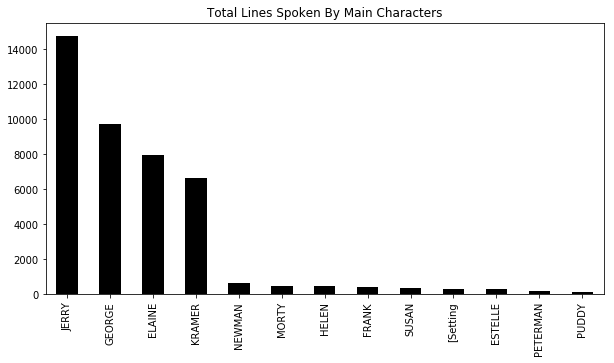

In [41]:
# Total Lines spoken by Character
df_scripts["Character"].value_counts().head(13).plot(kind="bar", 
                                                     figsize=(10,5),
                                                     title="Total Lines Spoken By Main Characters", 
                                                     colormap='gist_stern')

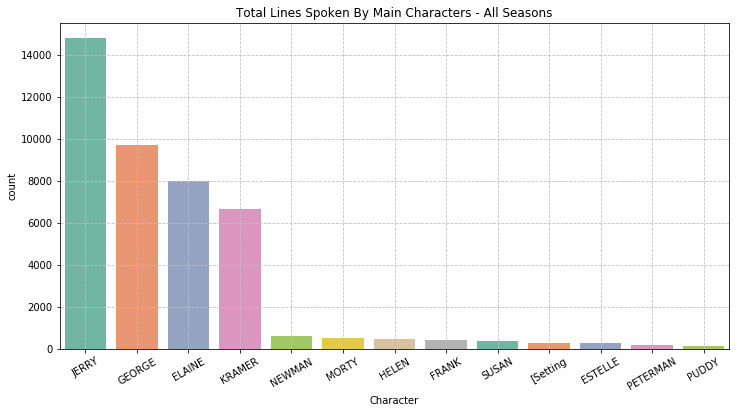

In [42]:
fig = plt.figure(figsize=(12,6))
ax = sns.countplot(x="Character", 
                   data=df_scripts, 
                   order=pd.value_counts(df_scripts['Character']).iloc[:13].index,
                   palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_title("Total Lines Spoken By Main Characters - All Seasons")
plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1));

In [43]:
df_scripts.head()

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0


In [44]:
# jerry_s01_ep01_corpus = df_jerry_s01_ep01['Dialogue'].to_list()

def agg_dialogue_by_episode(df):
    all_documents = []
    df_cols = ['Dialogue', 'Lines_of_Dialogue', 'SEID', 'Season', 'Episode']
    df_new = pd.DataFrame(columns = df_cols)
    
    index = 0
    for SEID in df['SEID'].unique():
        dialogue = df[df['SEID']==SEID]['Dialogue'].to_list()
        lines_of_dialogue = df[df['SEID']==SEID]['EpisodeNo'].count()
        season = df[df['SEID']==SEID]['Season'].unique()[0]
        episode = df[df['SEID']==SEID]['EpisodeNo'].unique()[0]
        
        df_new.loc[index] = [dialogue, lines_of_dialogue, SEID, season, episode]
        
        index += 1
        
    return df_new

In [45]:
df_scripts[df_scripts['Season']==1.0]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,2,GEORGE,Are you through?,0.0,S01E00,1.0
3,3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
5,5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",0.0,S01E00,1.0
7,7,JERRY,"Well, senator, Id just like to know, what you ...",0.0,S01E00,1.0
8,8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0
9,9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",0.0,S01E00,1.0


In [46]:
df_scripts['SEID'].unique().shape

(174,)

In [47]:
df_docs_by_ep = agg_dialogue_by_episode(df_scripts)

In [48]:
df_docs_by_ep.Dialogue[0]

['Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.',
 '(pointing at George

In [49]:
merged = pd.merge(df_docs_by_ep, df_info.iloc[:,3:], on=['SEID'], suffixes=['_ep', '_info'])

In [50]:
merged

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,IMDB_Rating
0,[Do you know what this is all about? Do you kn...,211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,7.7
1,"[So, Im on line at the supermarket. Two women ...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
2,"[So I move into the centre lane, now I get ahe...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,7.7
3,"[Most men like working on things. Tools, objec...",241,S01E03,1.0,3.0,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.5
4,[Went out to dinner the other night. Check cam...,230,S01E04,1.0,4.0,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
5,[Im always in traffic with the lane expert. Yo...,245,S02E01,2.0,1.0,The Ex-Girlfriend,16-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,7.8
6,[My parents live in Florida now. They moved th...,250,S02E02,2.0,2.0,The Pony Remark,30-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,8.0
7,"[I hate clothes, okay? I hate buying them. I h...",261,S02E03,2.0,3.0,The Jacket,6-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,8.4
8,[The bad thing about television is that everyb...,264,S02E04,2.0,4.0,The Phone Message,13-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,8.5
9,"[Well, I painted my apartment again. Ive been ...",281,S02E05,2.0,5.0,The Apartment,4-Apr-91,Peter Mehlman,Tom Cherones,8.0


In [51]:
df_info, df_scripts = cap.load_data()
df_docs_by_ep = cap.agg_dialogue_by_episode(df_scripts, df_info)

In [52]:
df_docs_by_ep.iloc[134, :].Dialogue

"I wouldn't walk over there. Why not? It's the most dangerous part of the sidewalk. Cab hops a curb, wap! You've had your last egg sandwich. What about over there? You know air conditioners fall out all the time. I'd much rather get hit by an 80 pound air conditioner than a two ton cab. No, cab's comin' in right here (Hand at waist) Set of plastic hips, prosthetic legs, and a monkey to answer the door, I'm back in business. Much rather take it to the head, Like I did in '79. You were livin' in the village then, right? Don't really remember. (Showing fingernails) Toxic waste green. That is disgusting. You know, revulsion has now become a valid form of attraction. Well, then you're drivin' me wild. I had 'em done for the big Peterman bash I'm throwin'. (George enters) Oh, why you havin' a party? I drive my people hard, and then I reward them. Like with dogs. Exactly. Party? Yeah. Food? Uh huh. Bar? Yeah. George? He's gonna show up anyway. George, I just don't want you interfering. How co

In [53]:
pd.options.display.max_colwidth = 1000

In [54]:
# How many Character lines contain a parenthesis?
df_scripts[df_scripts['Dialogue'].str.contains("uromycitisis")]                                       

,Character,Dialogue,EpisodeNo,SEID,Season
54480,JERRY,Because I could get uromycitisis poisoning and die - that's why.,23.0,S09E23,9.0


In [55]:
df_docs_by_ep.iloc[-1, :].Dialogue

'I can\'t eat this without catsup. Would it kill her to check up on us? Would that be a terrible thing? "How\'s everything? Do you need anything? What can I do for you?" I know what you mean. Do ya? It\'s like going out with someone and you never hear from them again. Same thing! Not really, but it\'s something. Ask the people behind you. Excuse me. Are you using your catsup? What do you think? You want to give him the catsup? It\'s up to you. You know what? I don\'t think so. I\'m going to need it from time to time. So what are you doing later? You want to go to the movies? Nah - what for? To see a movie. I\'ve been to the movies. Not this movie. They\'re all the same. You go, you sit, you eat popcorn, you watch. I\'m sick of it. Did you shower today? Yeah. That\'s usually the kind of mood I\'m in when I haven\'t showered. When is it going to be my turn, Jerry? When do I get my 15 minutes? I want my 15 minutes! Oh, quit complaining. At least you have your health. Ah! Health\'s not goo

In [56]:
df_scripts[df_scripts['SEID']=='S09E20']       

,Character,Dialogue,EpisodeNo,SEID,Season
53587,GEORGE,"Man, I'm starving.",20.0,S09E20,9.0
53588,ELAINE,How can you be hungry after what you ate at that Mets game?,20.0,S09E20,9.0
53589,GEORGE,Because ballpark food doesn't count as real food.,20.0,S09E20,9.0
53590,JERRY,Right. It's just an activity. It's like that paddle with the ball and the rubber band.,20.0,S09E20,9.0
53591,KRAMER,"You know, my friend Bob Saccamano made a fortune off of those. See he came up with the idea for the rubber band. Before that, people would just hit the ball, and it would fly away.",20.0,S09E20,9.0
53592,JERRY,I can't believe you all made me leave before the end of the game.,20.0,S09E20,9.0
53593,ELAINE,"Oh, come on, Jerry. It was 9 to nothing. We were getting shellacked.",20.0,S09E20,9.0
53594,GEORGE,Those nachos are killing me.,20.0,S09E20,9.0
53595,ELAINE,I thought you were hungry.,20.0,S09E20,9.0
53596,GEORGE,It's complicated.,20.0,S09E20,9.0


In [57]:
df_info

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID,IMDB_Rating
OverallEPNo,,,,,,,,
0,1,0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,S01E00,7.7
1,1,1,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01,7.7
2,1,2,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,S01E02,7.7
3,1,3,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E03,7.5
4,1,4,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E04,7.7
5,2,1,The Ex-Girlfriend,16-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E01,7.8
6,2,2,The Pony Remark,30-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E02,8.0
7,2,3,The Jacket,6-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E03,8.4
8,2,4,The Phone Message,13-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E04,8.5


In [58]:
df_docs_by_ep.head()

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,IMDB_Rating
0,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go. (pointing at Georges ...",211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,7.7
1,"So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the... Cheque. Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money bu...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
2,"So I move into the centre lane, now I get ahead of this women, who felt for some reason I guess, that she thought that I cut her off. So, she pulls up along side of me, gives me the finger. It seems like such an arbitrary, ridiculous thing to just pick a finger and you show it to the person. Its a finger, what does it mean? Someone shows me one of their fingers and Im supposed to feel bad. Is that the way its supposed to work? I mean, you could just give someone the toe, really, couldnt you? I would feel worse if I got the toe, than if I got the finger. Cause its not easy to give someone the toe, youve gotta get the shoe off, the sock off and drive, get it up and... (Jerry pretends to drive with one foot in the air, giving the toe.) Look at that toe, buddy. (He puts his foot down.) I mean, thats really insulting to get the toe, isnt it? Is that it? Got the cue tips, got the mini-umbrella, something boring to read on the plane. (Jerry zips his bag ceremoniously.) Thats it. Done! (cl...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,7.7
3,"Most men like working on things. Tools, objects, fixing things. This is what men enjoy doing. Have you ever noticed a guys out in his driveway working on something with tools, how all the other men in the neighborhood are magnetically drawn to this activity. They just come wandering out of the house like zombies. Men, its true, men hear a drill, its like a dog whistle. Just... (his head perks up) you know, they go running up to that living room curtain, Honey, I think Jims working on something over there. So they run over to the guy. Now they dont actually help the guy. No, they just want to hang around the area where work is being d

In [59]:
df_docs_by_ep.head()

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,IMDB_Rating
0,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go. (pointing at Georges ...",211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,7.7
1,"So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the... Cheque. Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money bu...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
2,"So I move into the centre lane, now I get ahead of this women, who felt for some reason I guess, that she thought that I cut her off. So, she pulls up along side of me, gives me the finger. It seems like such an arbitrary, ridiculous thing to just pick a finger and you show it to the person. Its a finger, what does it mean? Someone shows me one of their fingers and Im supposed to feel bad. Is that the way its supposed to work? I mean, you could just give someone the toe, really, couldnt you? I would feel worse if I got the toe, than if I got the finger. Cause its not easy to give someone the toe, youve gotta get the shoe off, the sock off and drive, get it up and... (Jerry pretends to drive with one foot in the air, giving the toe.) Look at that toe, buddy. (He puts his foot down.) I mean, thats really insulting to get the toe, isnt it? Is that it? Got the cue tips, got the mini-umbrella, something boring to read on the plane. (Jerry zips his bag ceremoniously.) Thats it. Done! (cl...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,7.7
3,"Most men like working on things. Tools, objects, fixing things. This is what men enjoy doing. Have you ever noticed a guys out in his driveway working on something with tools, how all the other men in the neighborhood are magnetically drawn to this activity. They just come wandering out of the house like zombies. Men, its true, men hear a drill, its like a dog whistle. Just... (his head perks up) you know, they go running up to that living room curtain, Honey, I think Jims working on something over there. So they run over to the guy. Now they dont actually help the guy. No, they just want to hang around the area where work is being d

In [60]:
corpus = df_docs_by_ep.Dialogue.values

In [61]:
corpus[-1]

'I can\'t eat this without catsup. Would it kill her to check up on us? Would that be a terrible thing? "How\'s everything? Do you need anything? What can I do for you?" I know what you mean. Do ya? It\'s like going out with someone and you never hear from them again. Same thing! Not really, but it\'s something. Ask the people behind you. Excuse me. Are you using your catsup? What do you think? You want to give him the catsup? It\'s up to you. You know what? I don\'t think so. I\'m going to need it from time to time. So what are you doing later? You want to go to the movies? Nah - what for? To see a movie. I\'ve been to the movies. Not this movie. They\'re all the same. You go, you sit, you eat popcorn, you watch. I\'m sick of it. Did you shower today? Yeah. That\'s usually the kind of mood I\'m in when I haven\'t showered. When is it going to be my turn, Jerry? When do I get my 15 minutes? I want my 15 minutes! Oh, quit complaining. At least you have your health. Ah! Health\'s not goo

In [62]:
corpus = [re.sub("\'", "", sent) for sent in corpus]
corpus = [sent.lower() for sent in corpus]

In [63]:
more_stop_words = ['ya', 'ha', 'mr', 'okay', 'ah', 'alright'] #'alright']
stop_words = text.ENGLISH_STOP_WORDS.union(more_stop_words)
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'ah',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'alright',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
  

In [64]:
vectorizer = CountVectorizer(stop_words=stop_words, max_features=3000, max_df = 0.85,  min_df=2)
tf = vectorizer.fit_transform(corpus)
tf = sp.csr_matrix.toarray(tf)

In [65]:
tf.shape

(174, 3000)

In [66]:
# num_topics = 10 produced really interesting results
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',random_state=32, n_jobs=-1)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=32, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [67]:
# phi is topics as rows and features (our tf-matrix in this case) as columns, which is the same as lda.components
phi = lda.components_
print(phi.shape)

# theta relates total episodes (as rows) to topics (as columns)
theta = lda.transform(tf)
print(theta.shape)
print(theta[0])

(10, 3000)
(174, 10)
[1.20061511e-04 1.20077282e-04 5.20965844e-01 2.89924595e-02
 1.20058395e-04 1.20058100e-04 1.20060457e-04 4.49201262e-01
 1.20054382e-04 1.20063835e-04]


In [68]:
#theses are the words in our bag of words
tf_feature_names = vectorizer.get_feature_names() 
tf_feature_names[::-1]

['zoo',
 'zone',
 'zip',
 'yup',
 'youve',
 'young',
 'youll',
 'youd',
 'yorker',
 'york',
 'yogurt',
 'yo',
 'yknow',
 'yesterday',
 'yep',
 'yells',
 'yellow',
 'yelling',
 'yelled',
 'yell',
 'years',
 'year',
 'yea',
 'ye',
 'yard',
 'yankees',
 'yankee',
 'yah',
 'wyck',
 'wrote',
 'wrong',
 'written',
 'writing',
 'writes',
 'writer',
 'write',
 'wrap',
 'wow',
 'wouldve',
 'wouldnt',
 'worthy',
 'worth',
 'worst',
 'worse',
 'worry',
 'worried',
 'worn',
 'worlds',
 'world',
 'works',
 'workout',
 'working',
 'worker',
 'worked',
 'work',
 'wore',
 'words',
 'word',
 'woody',
 'wood',
 'woo',
 'wont',
 'wondering',
 'wonderful',
 'wonder',
 'won',
 'womens',
 'women',
 'womans',
 'woman',
 'woah',
 'witness',
 'wish',
 'wise',
 'wipes',
 'wipe',
 'winter',
 'winner',
 'winks',
 'wing',
 'wine',
 'windows',
 'window',
 'wind',
 'win',
 'willie',
 'wilhelm',
 'wild',
 'wig',
 'wife',
 'wide',
 'whyd',
 'whos',
 'whoo',
 'whoa',
 'white',
 'whispers',
 'whispering',
 'whisper',
 '

In [69]:
def display_topics(model, feature_names, num_top_words):
    topic_dict = {}
    idx_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        
        topic_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        idx_dict[topic_idx] = topic.argsort()[:-num_top_words - 1:-1]
        
    return topic_dict, idx_dict

def display_articles(index, theta, titles, num_articles):
    article_chosen = titles[index]
    theta_dif = theta[index] 
    diff_mat = np.abs(np.sum(theta - theta_dif, axis=1))
    print("Article Chosen is: {}".format(article_chosen))
    print("\n".join([titles[i]
                        for i in diff_mat.argsort()[:num_articles+1]]))
          
        
def display_articles_cosine(index, theta, titles, num_articles):
    article_chosen = titles[index]
    theta_dif = theta[index] 
    diff_mat = pairwise_distances(theta_dif.reshape(1,-1),theta,metric='cosine')
    diff_mat = diff_mat.reshape(-1)
    print(diff_mat.argsort()[:num_articles+1])
    print("Title of Episode is: {}".format(article_chosen))
    print("\n".join([titles[i]
                        for i in diff_mat.argsort()[:num_articles+1]]))
    
def top_closest_episodes(episode, theta, titles, num_episodes):
    return titles[titles==episode].index[0]
    
    
def display_episodes_by_topics(theta, topic, titles, num_episodes):
    print("Topic Chosen is: {}".format(topic))
    print("\n".join(titles[theta[:, topic].argsort()[::-1][:num_episodes]]))

In [71]:
titles = df_docs_by_ep.Title.values

In [72]:
display_episodes_by_topics(theta, 0, titles, 10)

Topic Chosen is: 0
The Mom &amp; Pop Store
The Jimmy
The Shoes
The Stock Tip
The Heart Attack
The Outing
The Smelly Car
The Boyfriend (2)
The Engagement
The Subway


In [73]:
idx = int(np.where(titles=='The Wizard')[0])
print(titles[idx])
print(theta[idx])
print(theta[idx].argsort()[::-1])
print(np.argsort(theta[idx]))
print(phi[0])
print(theta[theta[:, 0].argsort()[::-1][:10]][:, 0])
print(titles[theta[:, 6].argsort()[::-1][:10]])

The Wizard
[1.31074419e-04 1.31088867e-04 1.31095865e-04 9.98820281e-01
 1.31070649e-04 1.31070148e-04 1.31072798e-04 1.31105024e-04
 1.31067288e-04 1.31074057e-04]
[3 7 2 1 0 9 6 4 5 8]
[8 5 4 6 9 0 1 2 7 3]
[0.26931807 0.34261154 0.33022511 ... 0.28716296 0.30089372 0.2809284 ]
[5.21782591e-01 1.62255403e-01 1.48038173e-01 1.28760211e-01
 1.07329669e-01 2.28858646e-04 2.04940133e-04 1.93070980e-04
 1.90860292e-04 1.87642536e-04]
['The Statue' 'The Hot Tub' 'The Keys' 'The Outing' 'The Smelly Car'
 'The Boyfriend (2)' 'The Engagement' 'The Subway' 'The Deal'
 'The Trip (2)']


In [74]:
num_top_words = 10
display_topics(lda, tf_feature_names, num_top_words)

Topic 0:
jon voight tim shoes russell jimmy pencil jimmys mom hospital
Topic 1:
car away talk help god getting hand candy clubs glasses
Topic 2:
new newman coffee head getting apartment happened bad phone jerrys
Topic 3:
day friend talk thanks getting bad phone long new work
Topic 4:
cashmere dot smell nana wagon drink noreen pbs red dick
Topic 5:
woman talk work happened day door car night away funny
Topic 6:
keys statue ray jean paul coincidence house apartment murphy em
Topic 7:
car door phone apartment new talk love getting woman night
Topic 8:
long phone talking face night id car dog room work
Topic 9:
marisa car tomei fruit murphy faked orgasm wanna love god


({0: ['jon',
   'voight',
   'tim',
   'shoes',
   'russell',
   'jimmy',
   'pencil',
   'jimmys',
   'mom',
   'hospital'],
  1: ['car',
   'away',
   'talk',
   'help',
   'god',
   'getting',
   'hand',
   'candy',
   'clubs',
   'glasses'],
  2: ['new',
   'newman',
   'coffee',
   'head',
   'getting',
   'apartment',
   'happened',
   'bad',
   'phone',
   'jerrys'],
  3: ['day',
   'friend',
   'talk',
   'thanks',
   'getting',
   'bad',
   'phone',
   'long',
   'new',
   'work'],
  4: ['cashmere',
   'dot',
   'smell',
   'nana',
   'wagon',
   'drink',
   'noreen',
   'pbs',
   'red',
   'dick'],
  5: ['woman',
   'talk',
   'work',
   'happened',
   'day',
   'door',
   'car',
   'night',
   'away',
   'funny'],
  6: ['keys',
   'statue',
   'ray',
   'jean',
   'paul',
   'coincidence',
   'house',
   'apartment',
   'murphy',
   'em'],
  7: ['car',
   'door',
   'phone',
   'apartment',
   'new',
   'talk',
   'love',
   'getting',
   'woman',
   'night'],
  8: ['long',


In [75]:
df_docs_by_ep

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,IMDB_Rating
0,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go. (pointing at Georges ...",211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,7.7
1,"So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the... Cheque. Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money bu...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
2,"So I move into the centre lane, now I get ahead of this women, who felt for some reason I guess, that she thought that I cut her off. So, she pulls up along side of me, gives me the finger. It seems like such an arbitrary, ridiculous thing to just pick a finger and you show it to the person. Its a finger, what does it mean? Someone shows me one of their fingers and Im supposed to feel bad. Is that the way its supposed to work? I mean, you could just give someone the toe, really, couldnt you? I would feel worse if I got the toe, than if I got the finger. Cause its not easy to give someone the toe, youve gotta get the shoe off, the sock off and drive, get it up and... (Jerry pretends to drive with one foot in the air, giving the toe.) Look at that toe, buddy. (He puts his foot down.) I mean, thats really insulting to get the toe, isnt it? Is that it? Got the cue tips, got the mini-umbrella, something boring to read on the plane. (Jerry zips his bag ceremoniously.) Thats it. Done! (cl...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,7.7
3,"Most men like working on things. Tools, objects, fixing things. This is what men enjoy doing. Have you ever noticed a guys out in his driveway working on something with tools, how all the other men in the neighborhood are magnetically drawn to this activity. They just come wandering out of the house like zombies. Men, its true, men hear a drill, its like a dog whistle. Just... (his head perks up) you know, they go running up to that living room curtain, Honey, I think Jims working on something over there. So they run over to the guy. Now they dont actually help the guy. No, they just want to hang around the area where work is being d

In [76]:
display_articles(1, theta, titles, 10)

Article Chosen is: The Stakeout
The Stakeout
The Frogger
The Hot Tub
The Outing
The Opposite
The Abstinence
The Face Painter
The Keys
The Bubble Boy
The Pledge Drive
The Junk Mail


In [77]:
display_articles_cosine(1, theta, titles, 10)

[  1  98 135  32 170 130  23  31  71 108  17]
Title of Episode is: The Stakeout
The Stakeout
The Beard
The Package
The Fix-Up
The Frogger
The Invitations
The Cafe
The Suicide
The Barber
The Postponement
The Note


In [78]:
lda.perplexity(tf)

2092.893819320376

In [79]:
# num_topics = 10 produced really interesting results

vectorizer = CountVectorizer(stop_words=stop_words, max_features=30000) #, max_df = 0.85,  min_df=2)
tf = vectorizer.fit_transform(corpus)
tf = sp.csr_matrix.toarray(tf)

num_topic_range = range(1,12)
for num_topics in num_topic_range:
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',random_state=32, n_jobs=-1)
    lda.fit(tf)
    print(f"Total Topics: {num_topics}")
    print(lda.perplexity(tf))
    print(lda.score(tf))

Total Topics: 1
2135.8704530431933
-1954062.8727982868
Total Topics: 2
2106.92222773375
-1950584.781942121
Total Topics: 3
2112.778798175961
-1951292.2812493222
Total Topics: 4
2131.667484041801
-1953560.8274043112
Total Topics: 5
2154.998275632459
-1956335.2856340923
Total Topics: 6
2184.7218208698973
-1959826.7670138804
Total Topics: 7
2217.8439147428626
-1963661.9331211685
Total Topics: 8
2251.149894485326
-1967461.0665927657
Total Topics: 9
2296.591180846936
-1972554.766921063
Total Topics: 10
2344.406049799541
-1977806.843837245
Total Topics: 11
2399.099559166347
-1983684.7096751342


In [80]:
corpus = df_docs_by_ep.Dialogue.values

# remove single quotes and convert to lower case
corpus = [re.sub("\'", "", sent) for sent in corpus]
corpus = [sent.lower() for sent in corpus]

# add to stop words
#more_stop_words = ['ya', 'ha', 'mr', 'okay', 'ah'] #<--- REMOVING 'alright' really changed things!
more_stop_words = ['ya', 'ha', 'mr', 'okay', 'ah', 'alright', 'apartment', 'talk', 
                   'happened', 'car', 'phone', 'looks', 'woman', 'getting', 'new', 
                   'day', 'talking', 'wanna', 'bad', 'love', 'looking', 'night',
                   'work', 'em', 'cmon', 'kind', 'god', 'coffee', 'friend', 'away', 'making']
stop_words = text.ENGLISH_STOP_WORDS.union(more_stop_words)

# create tf matrix from corpus - note this removes puncuation automatically
vectorizer = CountVectorizer(stop_words=stop_words, max_features=30000, max_df = 0.85,  min_df=2)
tf = vectorizer.fit_transform(corpus)
tf = sp.csr_matrix.toarray(tf)
tf_feature_names = vectorizer.get_feature_names() 
len(tf_feature_names)

8601

In [81]:
corpus = df_docs_by_ep.Dialogue.values

# remove single quotes and convert to lower case
corpus = [re.sub("\'", "", sent) for sent in corpus]
corpus = [sent.lower() for sent in corpus]

# add to stop words
#more_stop_words = ['ya', 'ha', 'mr', 'okay', 'ah'] #<--- REMOVING 'alright' really changed things!
more_stop_words = ['ya', 'ha', 'mr', 'okay', 'ah', 'alright', 'apartment', 'talk', 
                   'happened', 'car', 'phone', 'looks', 'woman', 'getting', 'new', 
                   'day', 'talking', 'wanna', 'bad', 'love', 'looking', 'night',
                   'work', 'em', 'cmon', 'kind', 'god', 'coffee', 'friend', 'away', 'making']
stop_words = text.ENGLISH_STOP_WORDS.union(more_stop_words)

# create tf matrix from corpus - note this removes puncuation automatically
vectorizer = CountVectorizer(stop_words=stop_words, max_features=3000, max_df = 0.85,  min_df=2)
tf = vectorizer.fit_transform(corpus)
tf = sp.csr_matrix.toarray(tf)

# num_topics = 10 produced really interesting results
# create LDA model using sklearn
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',random_state=32, n_jobs=-1)
lda.fit(tf)

# phi is topics as rows and features (our tf-matrix in this case) as columns, which is the same as lda.components
phi = lda.components_

# theta relates total episodes (as rows) to topics (as columns)
theta = lda.transform(tf)

# theses are the words in our bag of words
tf_feature_names = vectorizer.get_feature_names() 

# get titles from df
titles = df_docs_by_ep.Title.values

lda.perplexity(tf)

2209.0631231662665

Topic 0:
card christmas shop kruger happy bagel sub vest holiday strength
Topic 1:
door head better jerrys long hell leave thank lot guys
Topic 2:
paul jean keith wake alarm hernandez oneill latex morgan bitch
Topic 3:
soup bubble boy moops plane seinfeld leo chart hu write
Topic 4:
hear called lloyd dyou better vincent thousand shirt baby door
Topic 5:
salad smell dollars jacket ask drink cashmere dot wagon red
Topic 6:
newman coat joe bania chicken real keys feel room doctor
Topic 7:
bone koko maid clown money miss number coco pony grace
Topic 8:
label tim woody contd cars super bowl thirsty maker pretzels
Topic 9:
babu test funny bosco code mail cheryl pakistani lawyer course


KeyError: 10

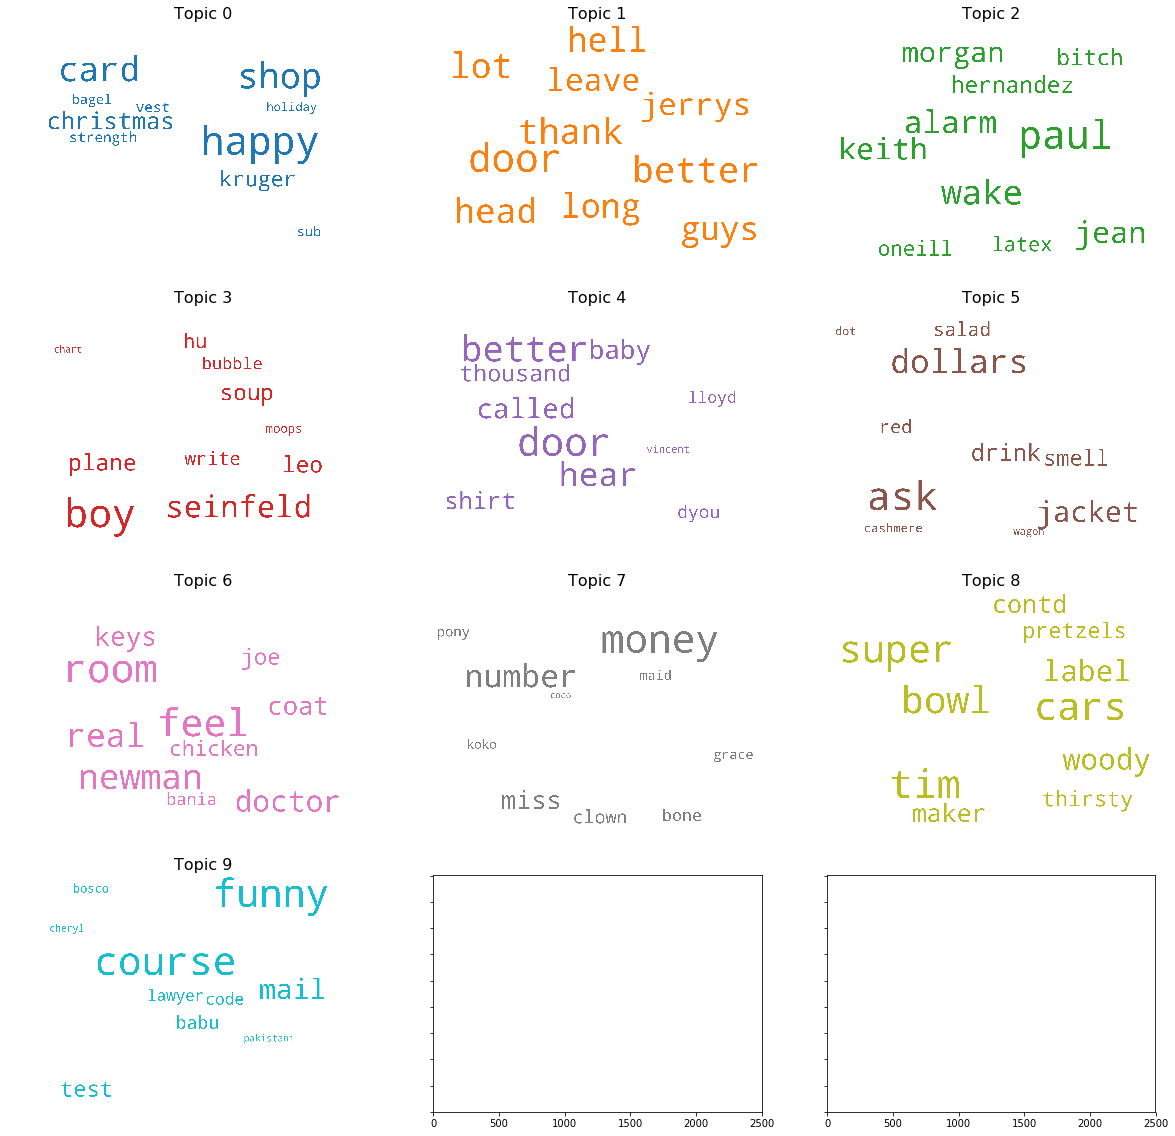

In [82]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors


ten_topics, idxs = display_topics(lda, tf_feature_names, num_top_words)

tot_dict = {}
new_dict = {}
for i, j in idxs.items():
    t_dict = {}
    for v in j:
        word = tf_feature_names[v]
        t_dict[word] = np.sum(tf[:, v])
        new_dict[i] = t_dict
        tot_dict.update(t_dict)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(4, 3, figsize=(20,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:12]):
    fig.add_subplot(ax)
    topic_words = new_dict[i]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#cloud.generate_from_frequencies(tot_dict, max_font_size=300)

In [ ]:
display_episodes_by_topics(theta, 8, titles, 10)

In [83]:
df_docs_by_ep.head(50)

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,IMDB_Rating
0,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go. (pointing at Georges ...",211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,7.7
1,"So, Im on line at the supermarket. Two women in front of me. One of them, her total was eight dollars, the other three dollars. They both of course choose to pay by the use of the... Cheque. Cheque. Now, the fact is, if its a woman in front of you thats writing the cheque, you will not be waiting long. I have noticed that women are very fast with cheques, yknow, cause they write out so many cheques. The keys, they can never find in their purse, they dont know where that is, but the cheque book they got that. They never fumble for the cheque book. The cheque book comes out of a holster (Jerry draws imaginary book from a holster.) Who do I make it out to? Theres my ID. Theres something about a cheque that, to a man, is not masculine. I dont know exactly what it is. I think to a man, a cheque is like a note from your mother that says, I dont have any money, but if youll contact these people, Im sure theyll stick up for me... If you just trust me this one time- I dont have any money bu...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
2,"So I move into the centre lane, now I get ahead of this women, who felt for some reason I guess, that she thought that I cut her off. So, she pulls up along side of me, gives me the finger. It seems like such an arbitrary, ridiculous thing to just pick a finger and you show it to the person. Its a finger, what does it mean? Someone shows me one of their fingers and Im supposed to feel bad. Is that the way its supposed to work? I mean, you could just give someone the toe, really, couldnt you? I would feel worse if I got the toe, than if I got the finger. Cause its not easy to give someone the toe, youve gotta get the shoe off, the sock off and drive, get it up and... (Jerry pretends to drive with one foot in the air, giving the toe.) Look at that toe, buddy. (He puts his foot down.) I mean, thats really insulting to get the toe, isnt it? Is that it? Got the cue tips, got the mini-umbrella, something boring to read on the plane. (Jerry zips his bag ceremoniously.) Thats it. Done! (cl...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,7.7
3,"Most men like working on things. Tools, objects, fixing things. This is what men enjoy doing. Have you ever noticed a guys out in his driveway working on something with tools, how all the other men in the neighborhood are magnetically drawn to this activity. They just come wandering out of the house like zombies. Men, its true, men hear a drill, its like a dog whistle. Just... (his head perks up) you know, they go running up to that living room curtain, Honey, I think Jims working on something over there. So they run over to the guy. Now they dont actually help the guy. No, they just want to hang around the area where work is being d